### Import Libaray

In [89]:
import MetaTrader5 as mt
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

import warnings 
warnings.filterwarnings("ignore")


### MT5 Initialize

In [2]:
# establish MetaTrader 5 connection to a specified trading account
if not mt.initialize(login=116662489,server="Exness-MT5Trial6",password="muxko9-boptEj"):
    print("initialize() failed, error code =",mt.last_error())
    quit()

# display data on connection status, server name and trading account
print(mt.terminal_info())

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=4361, maxbars=100000, codepage=0, ping_last=33391, community_balance=0.0, retransmission=0.12779742621927662, company='Exness Technologies Ltd', name='MetaTrader 5 EXNESS', language='English', path='C:\\Program Files\\MetaTrader 5 EXNESS', data_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\53785E099C927DB68A545C249CDBCE06', commondata_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


### Import data from MT5

In [48]:
symbol = "XAUUSDm" #gold
timeframe = mt.TIMEFRAME_M5 #5 minutes
utc_from = pd.Timestamp('2024-05-09') #start date
utc_to = pd.Timestamp.now() 

### Import to DataFrame

In [49]:
# Retrieve the data
rates = mt.copy_rates_range(symbol, timeframe, utc_from, utc_to)
df = pd.DataFrame(rates)
df

,time,open,high,low,close,tick_volume,spread,real_volume
0,1715212800,2308.733,2309.190,2308.125,2309.022,438,200,0
1,1715213100,2309.073,2309.170,2308.115,2308.257,351,200,0
2,1715213400,2308.219,2308.304,2307.851,2307.947,261,199,0
3,1715213700,2308.002,2308.386,2307.762,2308.179,241,200,0
4,1715214000,2308.209,2308.209,2307.815,2307.930,204,200,0
...,...,...,...,...,...,...,...,...
5836,1717745400,2375.140,2375.434,2373.562,2374.616,538,200,0
5837,1717745700,2374.625,2375.510,2372.872,2372.975,473,200,0
5838,1717746000,2372.956,2373.684,2372.823,2373.557,395,200,0
5839,1717746300,2373.564,2373.796,2372.746,2373.727,436,200,0


In [50]:
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1715212800,2308.733,2309.190,2308.125,2309.022,438,200,0
1,1715213100,2309.073,2309.170,2308.115,2308.257,351,200,0
2,1715213400,2308.219,2308.304,2307.851,2307.947,261,199,0
3,1715213700,2308.002,2308.386,2307.762,2308.179,241,200,0
4,1715214000,2308.209,2308.209,2307.815,2307.930,204,200,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5841 entries, 0 to 5840
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         5841 non-null   int64  
 1   open         5841 non-null   float64
 2   high         5841 non-null   float64
 3   low          5841 non-null   float64
 4   close        5841 non-null   float64
 5   tick_volume  5841 non-null   uint64 
 6   spread       5841 non-null   int32  
 7   real_volume  5841 non-null   uint64 
dtypes: float64(4), int32(1), int64(1), uint64(2)
memory usage: 342.4 KB


In [52]:
df.rename(columns={'time':'Date','open':'Open','high':'High','low':'Low','close':'Close'},inplace=True)
df = df.drop(['tick_volume', 'spread','real_volume'],axis=1)

In [53]:
df.head() # cehck the data after renaming

,Date,Open,High,Low,Close
0,1715212800,2308.733,2309.190,2308.125,2309.022
1,1715213100,2309.073,2309.170,2308.115,2308.257
2,1715213400,2308.219,2308.304,2307.851,2307.947
3,1715213700,2308.002,2308.386,2307.762,2308.179
4,1715214000,2308.209,2308.209,2307.815,2307.930


In [54]:
df.info() # Check data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5841 entries, 0 to 5840
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5841 non-null   int64  
 1   Open    5841 non-null   float64
 2   High    5841 non-null   float64
 3   Low     5841 non-null   float64
 4   Close   5841 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 228.3 KB


In [55]:
df.describe()

,Date,Open,High,Low,Close
count,5.841000e+03,5841.000000,5841.000000,5841.000000,5841.000000
mean,1.716517e+09,2361.167112,2362.049511,2360.271880,2361.175510
std,7.495365e+05,30.780434,30.858415,30.679494,30.768901
min,1.715213e+09,2307.469000,2308.109000,2306.455000,2307.497000
25%,1.715842e+09,2338.886000,2339.699000,2338.032000,2338.859000
50%,1.716471e+09,2353.139000,2353.888000,2352.184000,2353.164000
75%,1.717118e+09,2377.634000,2378.316000,2376.947000,2377.662000
max,1.717747e+09,2449.859000,2450.025000,2447.692000,2449.823000


In [56]:
df['Date'] = pd.to_datetime(df['Date'], unit='s')
df = df.rename(columns={'Date': 'Date/Time'})
df.set_index('Date/Time', inplace=True)
# df.reset_index(inplace=True)

In [57]:
# Display the first few rows of the DataFrame
df.head()

,Open,High,Low,Close
Date/Time,,,,
2024-05-09 00:00:00,2308.733,2309.190,2308.125,2309.022
2024-05-09 00:05:00,2309.073,2309.170,2308.115,2308.257
2024-05-09 00:10:00,2308.219,2308.304,2307.851,2307.947
2024-05-09 00:15:00,2308.002,2308.386,2307.762,2308.179
2024-05-09 00:20:00,2308.209,2308.209,2307.815,2307.930


In [58]:
df.tail()

,Open,High,Low,Close
Date/Time,,,,
2024-06-07 07:30:00,2375.140,2375.434,2373.562,2374.616
2024-06-07 07:35:00,2374.625,2375.510,2372.872,2372.975
2024-06-07 07:40:00,2372.956,2373.684,2372.823,2373.557
2024-06-07 07:45:00,2373.564,2373.796,2372.746,2373.727
2024-06-07 07:50:00,2373.706,2373.706,2373.009,2373.587


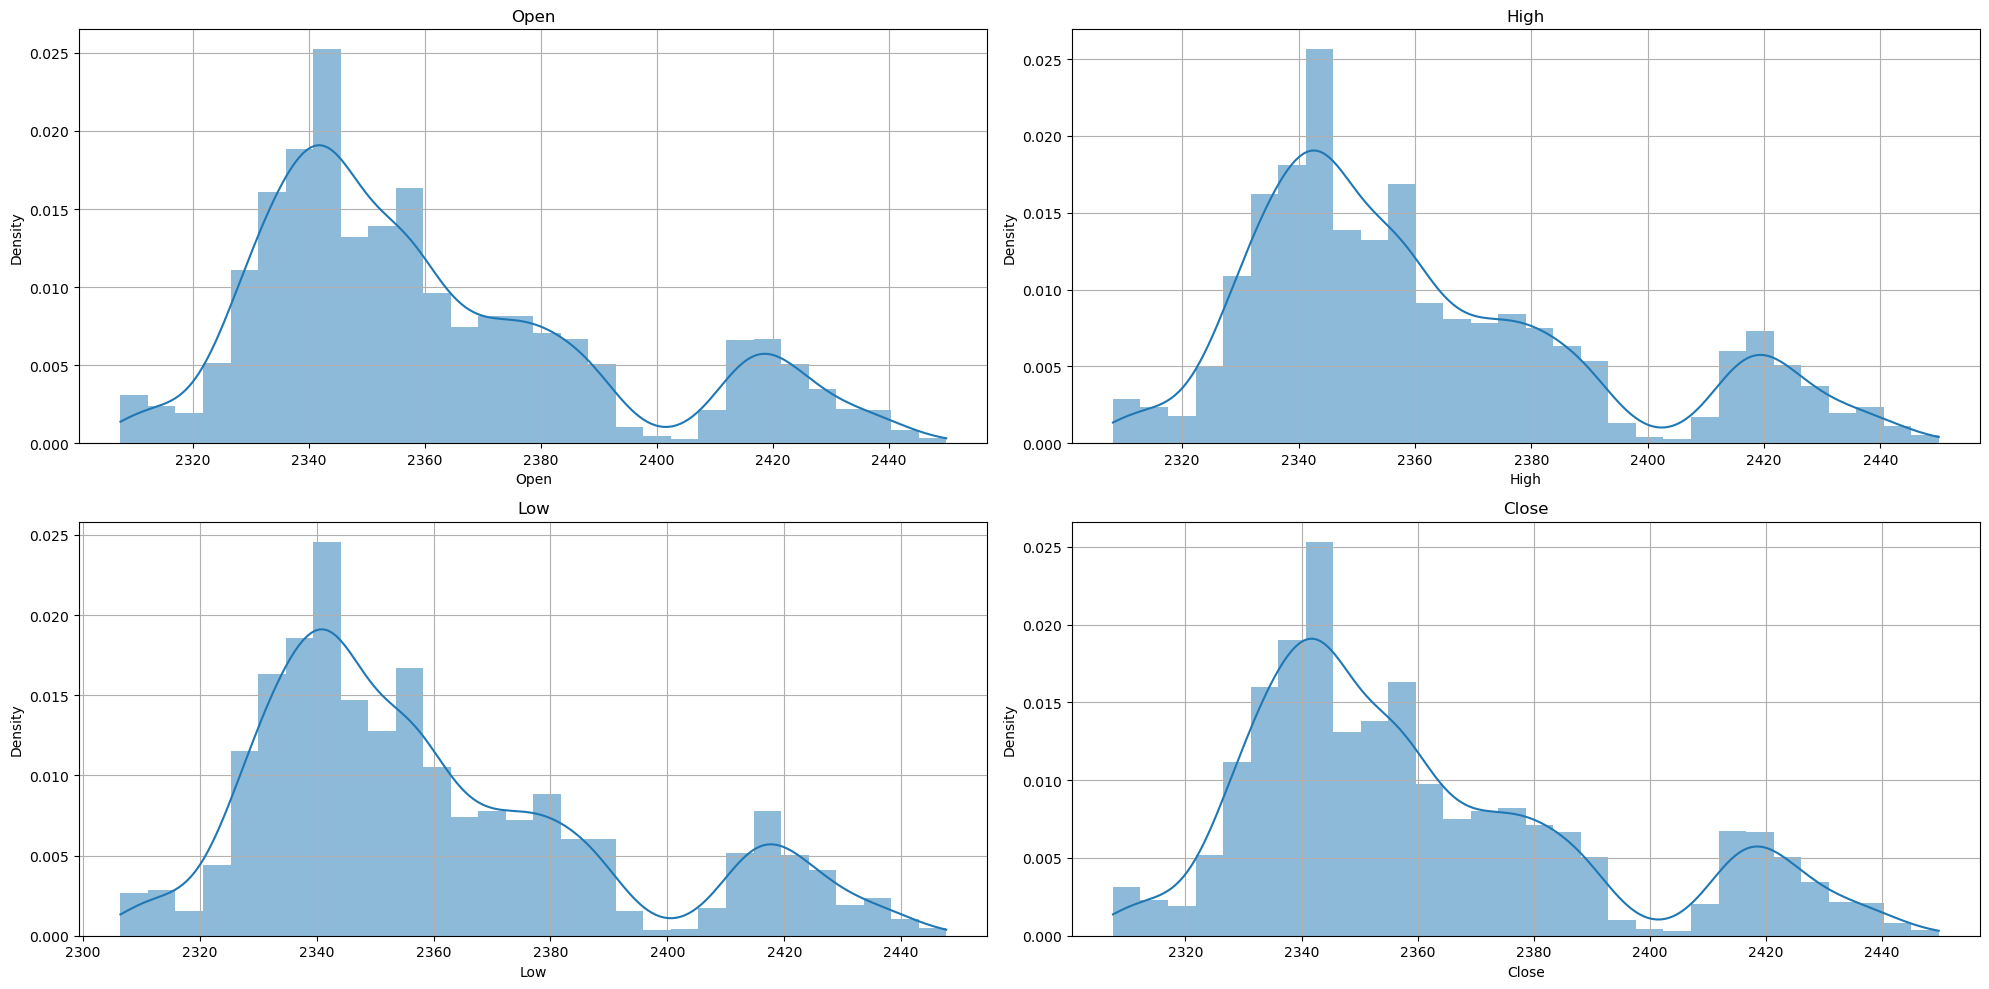

In [59]:
features = ['Open', 'High', 'Low', 'Close'] 

fig, axs = plt.subplots(2, 2, figsize=(20,10))

for i, col in enumerate(features): 
  ax = plt.subplot(2, 2, i+1)
  sns.histplot(df[col], label="100% Equities", kde=True, stat="density", linewidth=0, ax=ax, bins=30) 
  ax.set_title(col)
  ax.set_xlabel(col)
  ax.set_ylabel('Density')
  ax.grid()

plt.tight_layout()
plt.show()

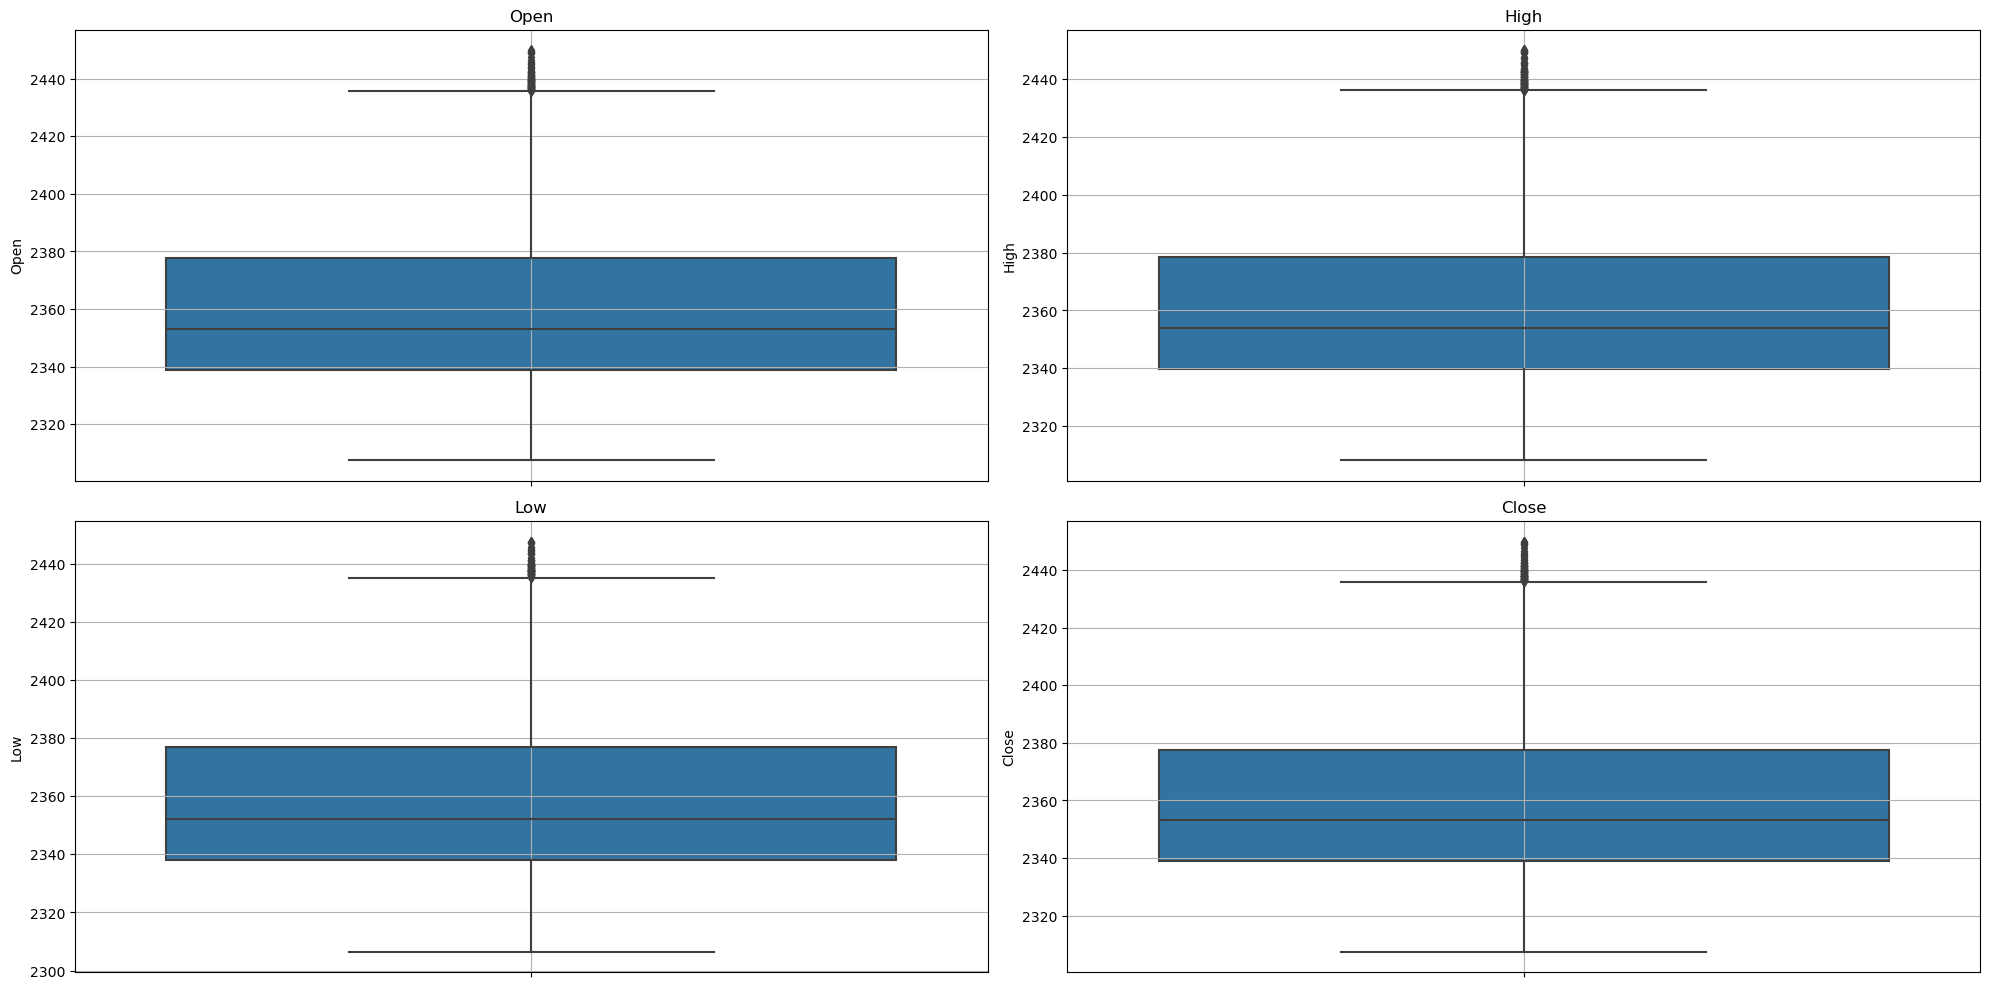

In [60]:
features = ['Open', 'High', 'Low', 'Close'] 

fig, axs = plt.subplots(2, 2, figsize=(20,10))

for i, col in enumerate(features): 
  ax = plt.subplot(2, 2, i+1)
  sns.boxplot(y=df[col], ax=ax) 
  ax.set_title(col)
  ax.set_xlabel('')
  ax.set_ylabel(col)
  ax.grid()

plt.tight_layout()
plt.show()

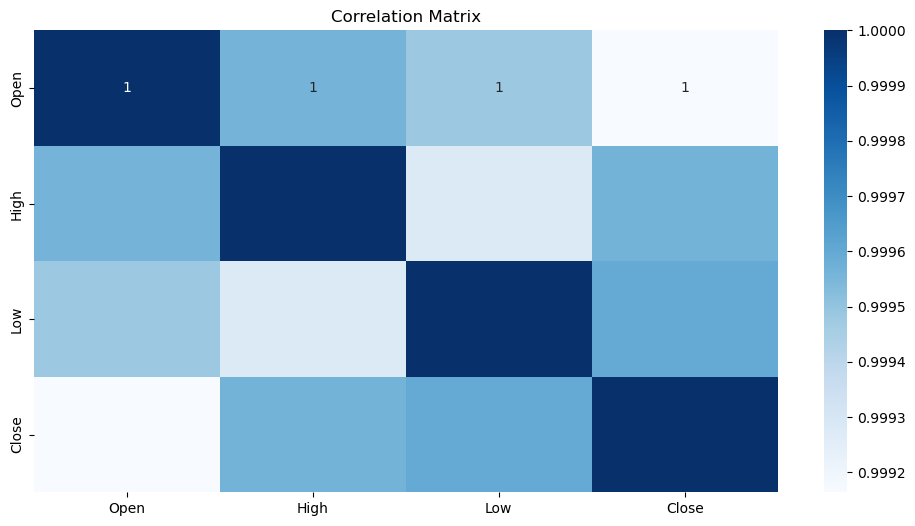

In [61]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()


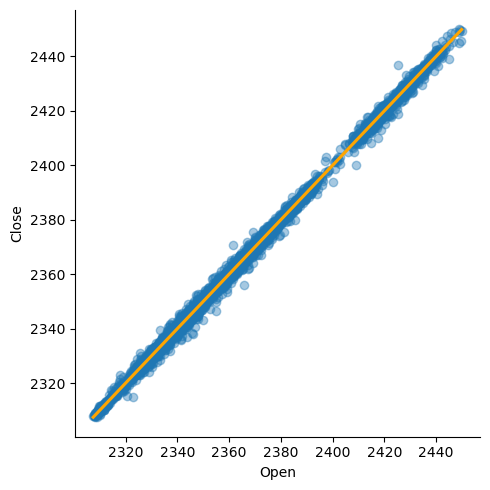

In [62]:
sns.lmplot(x='Open', y='Close', data=df, ci=None,
           scatter_kws={'alpha':0.4},
           line_kws={'color':'orange'})

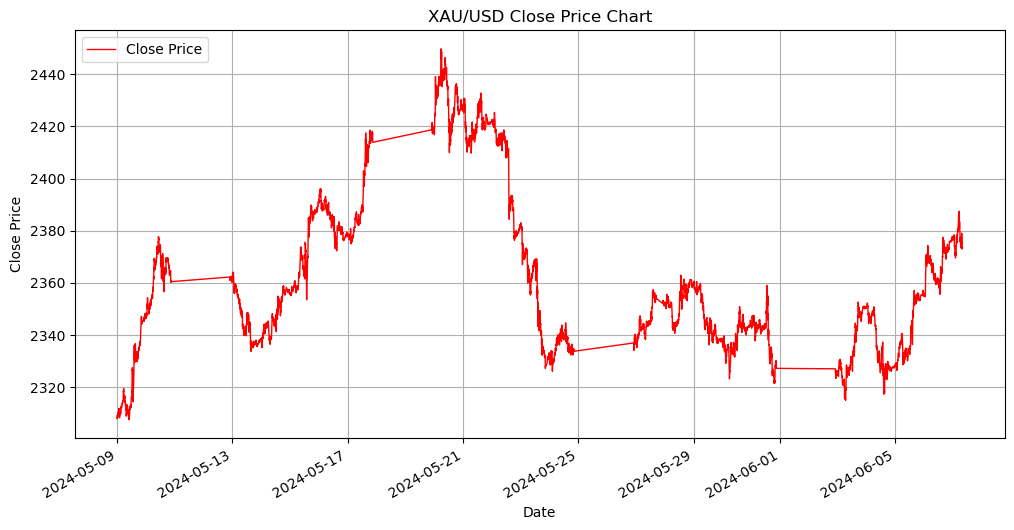

In [63]:
df_plot = df['Close'].plot(figsize=(12, 6), 
                           title='XAU/USD Close Price Chart', 
                           grid=True, 
                           color='red', 
                           label='Close Price',
                           lw=1)
df_plot.set_xlabel('Date')
df_plot.set_ylabel('Close Price')
df_plot.legend(loc='upper left')
plt.show()

In [64]:
df.duplicated().sum()

0

In [65]:
df.isnull().sum().sum()

0

In [66]:
# # get all data today for testing
# # Define the specific date
# specific_date = pd.Timestamp.today().normalize()
# print('Today(date-time):',specific_date)
# # Select the rows for the specific date
# df_specific_date = df[df.index.date == specific_date.date()]
# test_size = df_specific_date.shape[0]
# # Print the DataFrame for the specific date
# print('Test_size:',test_size)
# df_specific_date.head()


# get all data for the current month for testing
# Define the current month
current_month = pd.Timestamp.today().normalize().month
print('Current Month:', current_month)

# Select the rows for the current month
df_current_month = df[df.index.month == current_month]
test_size = df_current_month.shape[0]

# Print the DataFrame for the current month
print('Test_size:', test_size)
df_current_month.head()

Current Month: 6
Test_size: 1222


,Open,High,Low,Close
Date/Time,,,,
2024-06-02 22:05:00,2328.496,2328.760,2326.583,2327.009
2024-06-02 22:10:00,2327.043,2327.104,2324.172,2325.173
2024-06-02 22:15:00,2325.144,2326.622,2325.076,2325.931
2024-06-02 22:20:00,2325.932,2325.950,2324.535,2325.247
2024-06-02 22:25:00,2325.243,2325.243,2323.340,2323.340


In [70]:
# Define features
features = ['Open', 'High', 'Low', 'Close']
# Define window size
window_size = 25

# Initialize the MinMaxScaler for each feature
scalers = {feature: MinMaxScaler() for feature in features}

# Scale the data
scaled_data = {feature: scalers[feature].fit(df[feature].values.reshape(-1, 1)) for feature in features}

# Split the data into training and testing sets
train_data = {}
for feature in df.columns:
    train_data[feature] = df[feature][:-test_size]

test_data = {}
for feature in df.columns:
    test_data[feature] = df[feature][-test_size - window_size:]

train_data = {feature: scaled_data[feature].transform(train_data[feature].values.reshape(-1, 1)) for feature in df.columns}
test_data = {feature: scaled_data[feature].transform(test_data[feature].values.reshape(-1, 1)) for feature in df.columns}

# # Function to create sequences for training and testing
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# # Create sequences for training and testing
X_train = {feature: [] for feature in features}
y_train = {feature: [] for feature in features}
X_test = {feature: [] for feature in features}
y_test = {feature: [] for feature in features}


for feature in features:
    X_train[feature], y_train[feature] = create_sequences(train_data[feature], window_size)
    X_test[feature], y_test[feature] = create_sequences(test_data[feature], window_size)


for feature in features:
    X_train[feature] = np.array(X_train[feature])
    y_train[feature] = np.array(y_train[feature])
    X_test[feature] = np.array(X_test[feature])
    y_test[feature] = np.array(y_test[feature])

for feature in features:
    X_train[feature] = X_train[feature].reshape(X_train[feature].shape[0], X_train[feature].shape[1], 1)
    X_test[feature] = X_test[feature].reshape(X_test[feature].shape[0], X_test[feature].shape[1], 1)
    y_train[feature] = y_train[feature].reshape(-1, 1)
    y_test[feature] = y_test[feature].reshape(-1, 1)

# # Print the shapes of the training and testing data for each feature
for feature in features:
    print(f"{feature} - X_train shape: {X_train[feature].shape}, y_train shape: {y_train[feature].shape}")
    print(f"{feature} - X_test shape: {X_test[feature].shape}, y_test shape: {y_test[feature].shape}")
    print("-"*30)


Open - X_train shape: (4594, 25, 1), y_train shape: (4594, 1)
Open - X_test shape: (1222, 25, 1), y_test shape: (1222, 1)
------------------------------
High - X_train shape: (4594, 25, 1), y_train shape: (4594, 1)
High - X_test shape: (1222, 25, 1), y_test shape: (1222, 1)
------------------------------
Low - X_train shape: (4594, 25, 1), y_train shape: (4594, 1)
Low - X_test shape: (1222, 25, 1), y_test shape: (1222, 1)
------------------------------
Close - X_train shape: (4594, 25, 1), y_train shape: (4594, 1)
Close - X_test shape: (1222, 25, 1), y_test shape: (1222, 1)
------------------------------


In [71]:
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [78]:
# Initialize empty DataFrames for actual and predicted values
df_actual = pd.DataFrame(index=df.index[-test_size-window_size:-window_size])
df_pred = pd.DataFrame(index=df.index[-test_size-window_size:-window_size])

# Loop through each feature
for feature in features:
    # Train the model
    model = define_model()
    history = model.fit(X_train[feature], y_train[feature], epochs=150, batch_size=32, 
                         validation_split=0,
                         verbose=1)
    
    result = model.evaluate(X_test[feature], y_test[feature])
    y_pred = model.predict(X_test[feature])
    
    # Use the scaler for the current feature to inverse transform the data
    y_test_true = scalers[feature].inverse_transform(y_test[feature])
    y_test_pred = scalers[feature].inverse_transform(y_pred)

    # Flatten the arrays
    y_test_true = y_test_true.ravel()
    y_test_pred = y_test_pred.ravel()

    # Create DataFrames for actual and predicted values for the current feature
    df_actual_feature = pd.DataFrame({f'{feature}': y_test_true}, index=df.index[-test_size-window_size:-window_size])
    df_pred_feature = pd.DataFrame({f'{feature}': y_test_pred}, index=df.index[-test_size-window_size:-window_size])
    
    # Concatenate the DataFrames for the current feature with the overall DataFrames
    df_actual = pd.concat([df_actual, df_actual_feature], axis=1)
    df_pred = pd.concat([df_pred, df_pred_feature], axis=1)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 25, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 25, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.0882
Epoch 2/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0091
Epoch 3/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0031
Epoch 4/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0017
Epoch 5/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0012
Epoch 6/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0011
Epoch 7/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 9.5249e-04
Epoch 8/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 8.6634e-04
Epoch 9/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 7.7271e-04
Epoch 10/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 7.2576e-04
Epoch 11/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 7.0289e-04
Epoch 12/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 5.9470e-04
Epoch 13/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 5.9596e-04
Epoch 14/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 5.8849e

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 25, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 25, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 0.0907
Epoch 2/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0087
Epoch 3/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0024
Epoch 4/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0015
Epoch 5/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0011
Epoch 6/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0010
Epoch 7/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 9.5060e-04
Epoch 8/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 8.7633e-04
Epoch 9/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 7.9384e-04
Epoch 10/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 6.8854e-04
Epoch 11/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 6.6416e-04
Epoch 12/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 6.1509e-04
Epoch 13/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 5.9522e-04
Epoch 14/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 5.7844e

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 25, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 25, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 0.0695
Epoch 2/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0070
Epoch 3/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0023
Epoch 4/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0015
Epoch 5/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0011
Epoch 6/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 9.6069e-04
Epoch 7/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 8.8231e-04
Epoch 8/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 8.2444e-04
Epoch 9/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 7.9548e-04
Epoch 10/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 7.4918e-04
Epoch 11/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 6.3831e-04
Epoch 12/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.2793e-04
Epoch 13/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.0599e-04
Epoch 14/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 5.6

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 25, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 25, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.0797
Epoch 2/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0134
Epoch 3/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0039
Epoch 4/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0017
Epoch 5/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0013
Epoch 6/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0010
Epoch 7/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 9.7158e-04
Epoch 8/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 8.2982e-04
Epoch 9/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 7.6265e-04
Epoch 10/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 7.3479e-04
Epoch 11/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.6733e-04
Epoch 12/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 6.0259e-04
Epoch 13/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 5.5209e-04
Epoch 14/150
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 5.4204e

In [79]:
df_actual.head()

,Open,High,Low,Close
Date/Time,,,,
2024-05-31 18:55:00,2328.496,2328.760,2326.583,2327.009
2024-05-31 19:00:00,2327.043,2327.104,2324.172,2325.173
2024-05-31 19:05:00,2325.144,2326.622,2325.076,2325.931
2024-05-31 19:10:00,2325.932,2325.950,2324.535,2325.247
2024-05-31 19:15:00,2325.243,2325.243,2323.340,2323.340


In [80]:
df_pred.head()

,Open,High,Low,Close
Date/Time,,,,
2024-05-31 18:55:00,2327.918945,2328.204346,2326.094727,2326.475586
2024-05-31 19:00:00,2328.517334,2328.789062,2325.583008,2326.397949
2024-05-31 19:05:00,2327.420410,2327.152588,2323.391357,2324.906738
2024-05-31 19:10:00,2325.617432,2326.748535,2323.948975,2325.175781
2024-05-31 19:15:00,2326.077393,2326.112549,2323.739014,2324.943604


In [81]:
metrics = []
# Train and evaluate a separate model for each feature
for feature in features:
 
    # Calculate the metrics
    mae = mean_absolute_error(y_test[feature], y_pred)
    mse = mean_squared_error(y_test[feature], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[feature], y_pred)
    # Append the metrics to the list
    metrics.append([feature, mae, mse, rmse, r2, r2 * 100])

# Convert the metrics list to a DataFrame
metrics_df = pd.DataFrame(metrics, columns=['Feature', 'MAE', 'MSE', 'RMSE', 'R2', 'R2 (%)'])
metrics_df.head()

,Feature,MAE,MSE,RMSE,R2,R2 (%)
0,Open,0.002969,0.000015,0.003843,0.999090,99.909026
1,High,0.005106,0.000055,0.007425,0.996621,99.662083
2,Low,0.006190,0.000061,0.007787,0.996340,99.633969
3,Close,0.006520,0.000083,0.009084,0.994926,99.492566


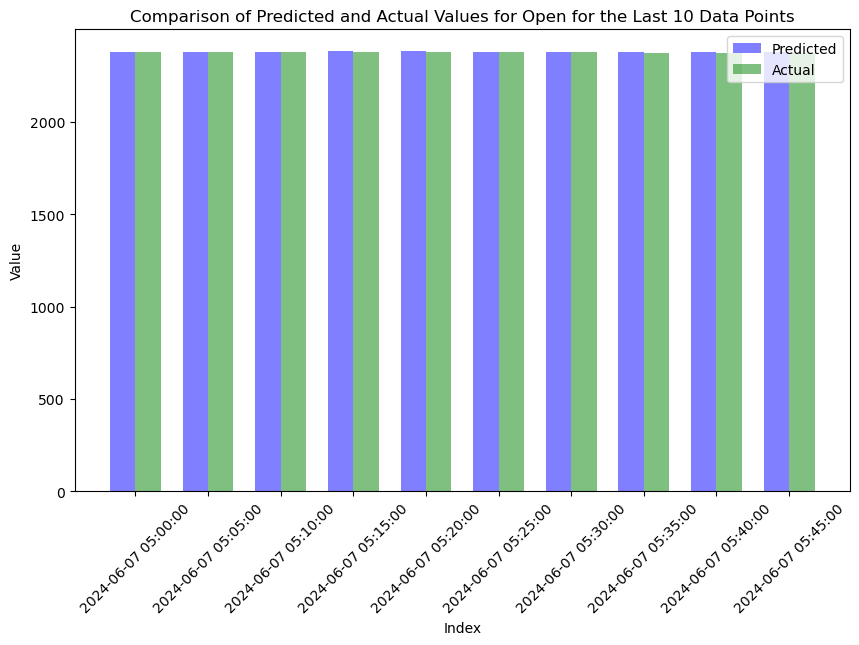

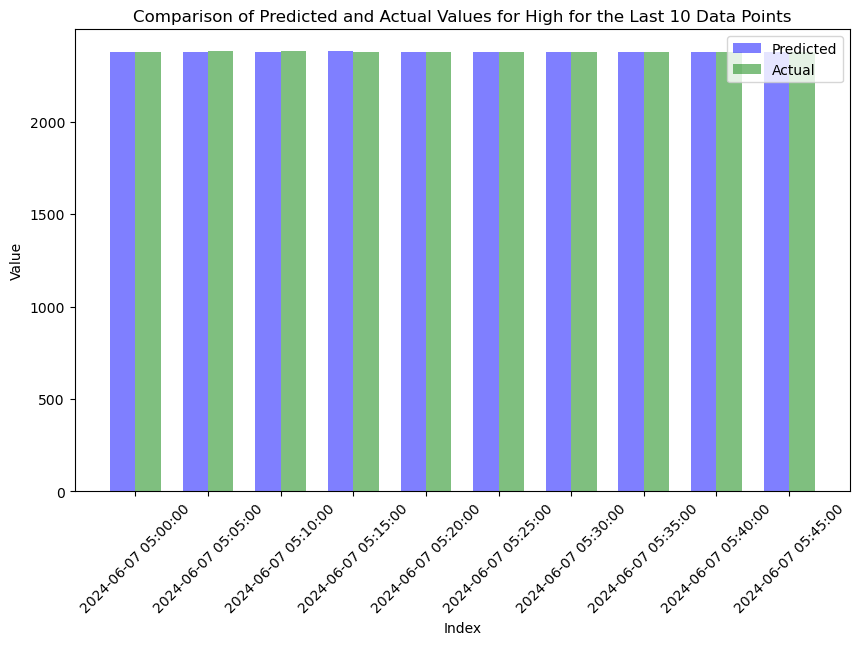

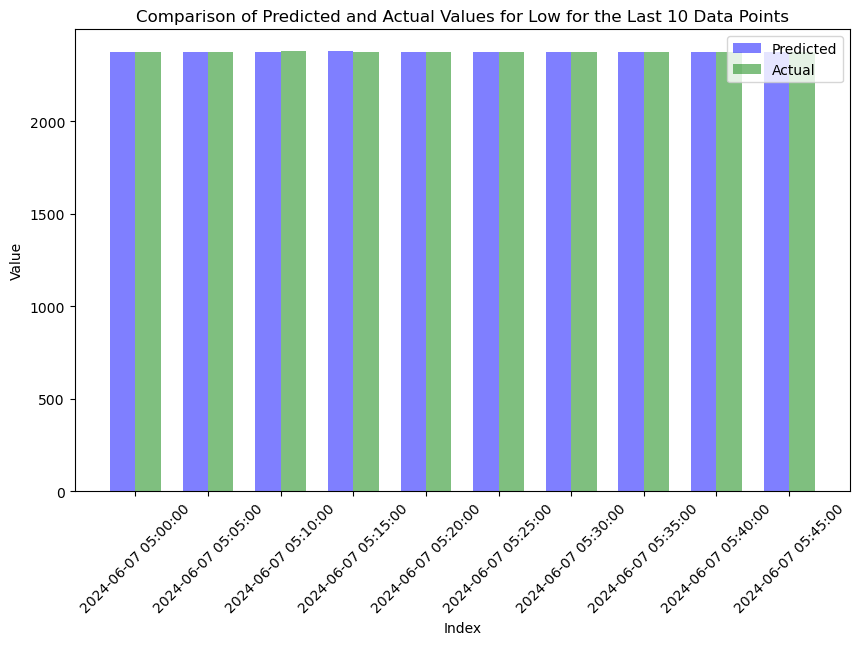

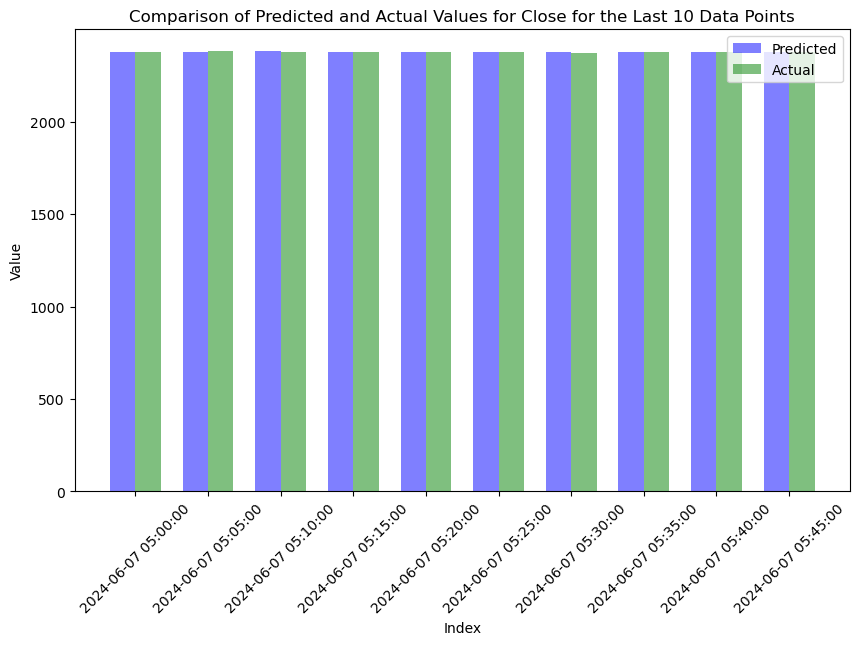

In [82]:
import numpy as np

# Get the indices
indices = df_pred.index[-10:]  # Select the last 10 indices

# Define the width of the bars
bar_width = 0.35

# Create an array of indices for positioning the bars
x = np.arange(len(indices))

# Iterate over each feature
for feature in features:
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot the predicted values
    plt.bar(x - bar_width/2, df_pred[feature][-10:], color='blue', width=bar_width, alpha=0.5, label='Predicted')

    # Plot the actual values
    plt.bar(x + bar_width/2, df_actual[feature][-10:], color='green', width=bar_width, alpha=0.5, label='Actual')

    # Set the x-axis ticks and labels
    plt.xticks(x, indices, rotation=45)  # Rotate the x-labels by 45 degrees

    # Set the x-axis label
    plt.xlabel('Index')

    # Set the y-axis label
    plt.ylabel('Value')

    # Set the title
    plt.title(f'Comparison of Predicted and Actual Values for {feature} for the Last 10 Data Points')

    # Set the legend
    plt.legend()

    # Show the plot
    plt.show()


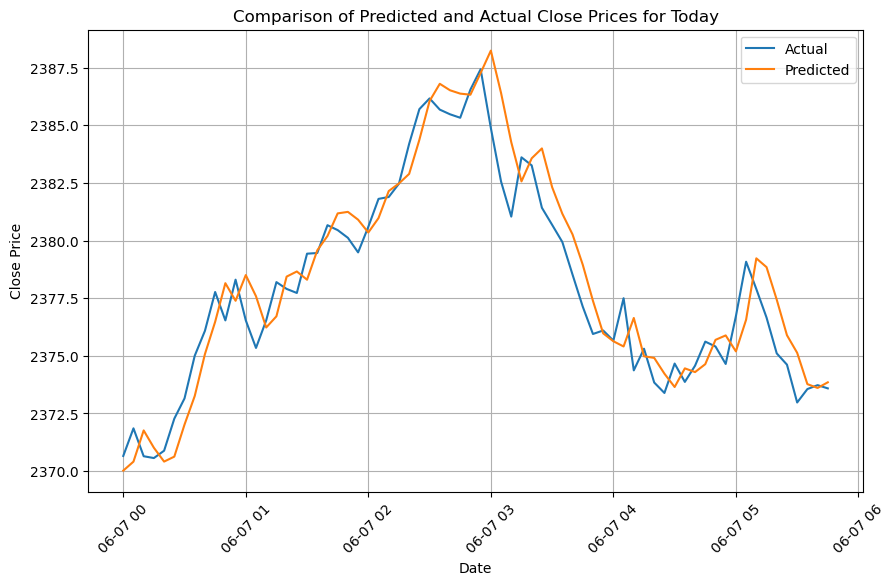

In [85]:
import datetime
# Get today's date
today = datetime.date.today()

# Filter the data for today
df_actual_today = df_actual[df_actual.index.date == today]
df_pred_today = df_pred[df_pred.index.date == today]

# Plot the actual and predicted values for today
plt.figure(figsize=(10, 6))
plt.plot(df_actual_today['Close'], label='Actual')
plt.plot(df_pred_today['Close'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Comparison of Predicted and Actual Close Prices for Today')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [96]:
class MyStrategy(Strategy):

    stop_loss = 6  
    n1 = 10 # fast MA
    n2 = 100 # slow MA
    def init(self):
        # Define the indicators you want to use
        self.ma1 = self.I(SMA, self.data.Close, self.n1)
        self.ma2 = self.I(SMA, self.data.Close, self.n2)

    def next(self):
        # If the fast MA crosses above the slow MA, buy the asset
        if crossover(self.ma1, self.ma2):
            self.position.close()  # Close any existing position
            self.buy()
        # If the fast MA crosses below the slow MA, sell the asset and set a stop loss
        elif crossover(self.ma2, self.ma1):
            self.position.close()
            self.sell(sl=self.data.Close[-1] * (1 + self.stop_loss))  # stop loss

# Get your data
data = df_pred

# Initialize the backtest
bt = Backtest(data, MyStrategy, cash=10000,commission=.0025,
              exclusive_orders=True)
bt.run()

# stats = bt.optimize(n1=range(10, 50, 5),
#                     n2=range(20, 200, 10),
#                     maximize='Return [%]',
#                     constraint=lambda param: param.n1 < param.n2)

# Print the stats
# print(stats)


bt.plot()
# Run the backtest
output = bt.run()


# # Print the output
print(output)

Start                     2024-05-31 18:55:00
End                       2024-06-07 05:45:00
Duration                      6 days 10:50:00
Exposure Time [%]                   90.425532
Equity Final [$]                  9807.610725
Equity Peak [$]                  10094.137239
Return [%]                          -1.923893
Buy & Hold Return [%]                2.036321
Return (Ann.) [%]                  -50.309208
Volatility (Ann.) [%]                4.997603
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.005101
Avg. Drawdown [%]                   -0.416439
Max. Drawdown Duration        3 days 14:45:00
Avg. Drawdown Duration        0 days 09:31:00
# Trades                                   18
Win Rate [%]                        22.222222
Best Trade [%]                       0.919965
Worst Trade [%]                     -0.479161
Avg. Trade [%]                    